In [1]:
# Import các thư viện cần thiết 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

import joblib  # Thư viện để lưu và tải mô hình


In [2]:
# 1. Tiền xử lý dữ liệu

# Đọc dữ liệu từ file CSV
data = pd.read_csv('housing.csv')

# Xử lý giá trị thiếu
data = data.dropna()

# Chuyển đổi biến phân loại thành biến giả (one-hot encoding)
data = pd.get_dummies(data, columns=['ocean_proximity'])

# Lưu danh sách các cột đặc trưng
feature_columns = data.drop('median_house_value', axis=1).columns.tolist()

# Chia dữ liệu thành X và y
X = data.drop('median_house_value', axis=1)
y = data['median_house_value']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Lưu trữ tên các cột để tái tạo DataFrame sau khi chuẩn hóa
feature_names = X_train_raw.columns


In [3]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# Chuyển đổi lại thành DataFrame để dễ thao tác
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)


In [4]:
# 2. Xây dựng và huấn luyện các mô hình

# 2.1 Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Lưu mô hình Linear Regression
joblib.dump(lr, 'linear_regression_model.joblib')


['linear_regression_model.joblib']

In [5]:
# 2.2 Ridge Regression với GridSearchCV để tìm alpha tối ưu
ridge = Ridge()
parameters_ridge = {'alpha': [0.1, 1, 10, 100, 200]}
ridge_cv = GridSearchCV(ridge, parameters_ridge, cv=5)
ridge_cv.fit(X_train, y_train)
print("\nBest alpha for Ridge Regression:", ridge_cv.best_params_)
y_pred_ridge = ridge_cv.predict(X_test)

# Lưu mô hình Ridge Regression tốt nhất
joblib.dump(ridge_cv.best_estimator_, 'ridge_regression_model.joblib')



Best alpha for Ridge Regression: {'alpha': 10}


['ridge_regression_model.joblib']

In [6]:
# 2.3 MLP Regressor với GridSearchCV và sử dụng Early Stopping
mlp = MLPRegressor(
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    tol=1e-4
)

parameter_space_mlp = {
    'hidden_layer_sizes': [(30,), (50,), (50, 30)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam'],
    'alpha': [0.01, 0.1, 1],
    'learning_rate': ['constant', 'adaptive'],
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mlp_cv = GridSearchCV(mlp, parameter_space_mlp, n_jobs=-1, cv=kf)
mlp_cv.fit(X_train, y_train)
print("\nBest parameters for MLP Regressor:", mlp_cv.best_params_)
y_pred_mlp = mlp_cv.predict(X_test)

# Lưu mô hình MLP Regressor tốt nhất
joblib.dump(mlp_cv.best_estimator_, 'mlp_regressor_model.joblib')

# Lưu trữ loss_curve_ của MLP Regressor
mlp_loss_curve = mlp_cv.best_estimator_.loss_curve_



Best parameters for MLP Regressor: {'activation': 'relu', 'alpha': 1, 'hidden_layer_sizes': (50, 30), 'learning_rate': 'constant', 'solver': 'adam'}


c:\Users\Macbook Pro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [7]:
# 3. Xây dựng và huấn luyện Stacking Regressor với MLP Regressor làm final_estimator

# Danh sách các mô hình cơ bản (base estimators)
estimators = [
    ('lr', lr),
    ('ridge', ridge_cv.best_estimator_),
    ('mlp', mlp_cv.best_estimator_)
]

# Cấu hình MLP Regressor làm final_estimator với các tham số đã điều chỉnh
final_mlp = MLPRegressor(
    hidden_layer_sizes=(50, 30),
    activation='relu',
    solver='adam',
    alpha=0.1,
    learning_rate='adaptive',
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    tol=1e-4,
    random_state=42
)

# Tạo Stacking Regressor
stacking_regressor_mlp = StackingRegressor(
    estimators=estimators,
    final_estimator=final_mlp,
    passthrough=False,
    n_jobs=-1
)

# Huấn luyện Stacking Regressor
stacking_regressor_mlp.fit(X_train, y_train)
y_pred_stack_mlp = stacking_regressor_mlp.predict(X_test)

# Lưu mô hình Stacking Regressor
joblib.dump(stacking_regressor_mlp, 'stacking_regressor_model.joblib')

# Lưu trữ loss_curve_ của final_estimator trong Stacking Regressor
stacking_mlp_loss_curve = stacking_regressor_mlp.final_estimator_.loss_curve_


In [8]:
# 4. Đánh giá các mô hình

def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"{model_name} - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")


In [9]:
print("\nĐánh giá mô hình trên tập huấn luyện:")
evaluate_model(y_train, lr.predict(X_train), "Linear Regression")
evaluate_model(y_train, ridge_cv.predict(X_train), "Ridge Regression")
evaluate_model(y_train, mlp_cv.predict(X_train), "MLP Regressor")
evaluate_model(y_train, stacking_regressor_mlp.predict(X_train), "Stacking Regressor")



Đánh giá mô hình trên tập huấn luyện:
Linear Regression - MAE: 49643.65, MSE: 4693460322.61, RMSE: 68508.83
Ridge Regression - MAE: 49543.51, MSE: 4690613124.21, RMSE: 68488.05
MLP Regressor - MAE: 44864.76, MSE: 4090953276.37, RMSE: 63960.56
Stacking Regressor - MAE: 44797.62, MSE: 4078000464.96, RMSE: 63859.22


In [10]:
print("\nĐánh giá mô hình trên tập kiểm tra:")
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_ridge, "Ridge Regression")
evaluate_model(y_test, y_pred_mlp, "MLP Regressor")
evaluate_model(y_test, y_pred_stack_mlp, "Stacking Regressor")



Đánh giá mô hình trên tập kiểm tra:
Linear Regression - MAE: 50506.19, MSE: 4808389460.57, RMSE: 69342.55
Ridge Regression - MAE: 50404.48, MSE: 4802346500.28, RMSE: 69298.96
MLP Regressor - MAE: 45848.55, MSE: 4201819817.53, RMSE: 64821.45
Stacking Regressor - MAE: 45764.38, MSE: 4180683493.66, RMSE: 64658.21


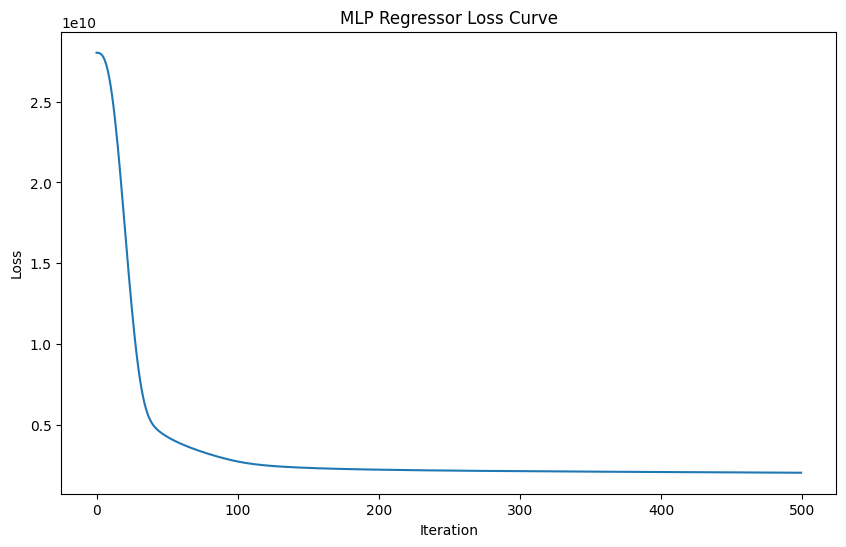

In [11]:
# 5. Trực quan hóa hàm mất mát (Loss Function)

# 5.1 Loss curve của MLP Regressor
plt.figure(figsize=(10,6))
plt.plot(mlp_loss_curve)
plt.title("MLP Regressor Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()


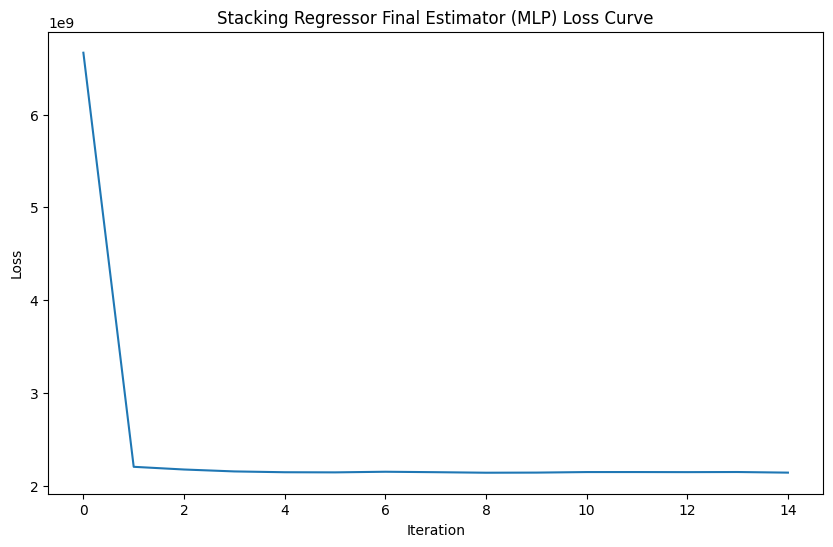

In [12]:
# 5.2 Loss curve của final_estimator trong Stacking Regressor
plt.figure(figsize=(10,6))
plt.plot(stacking_mlp_loss_curve)
plt.title("Stacking Regressor Final Estimator (MLP) Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()


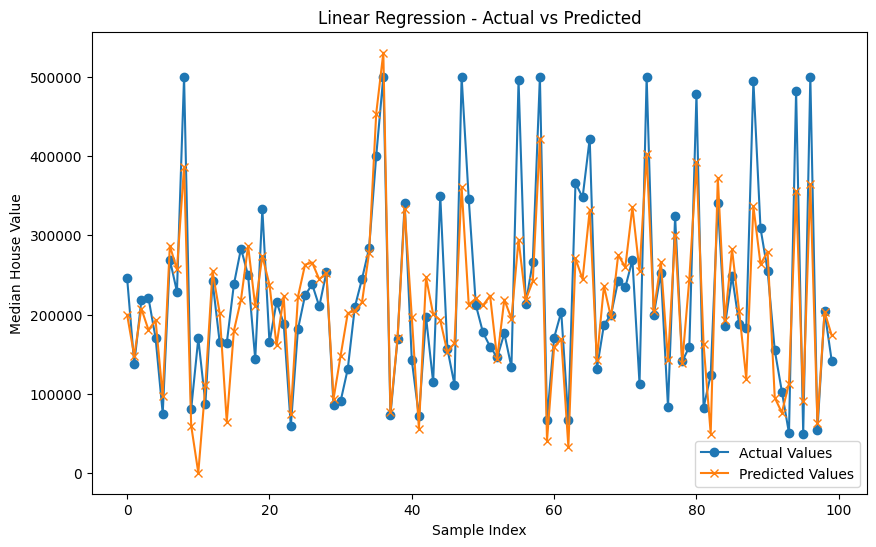

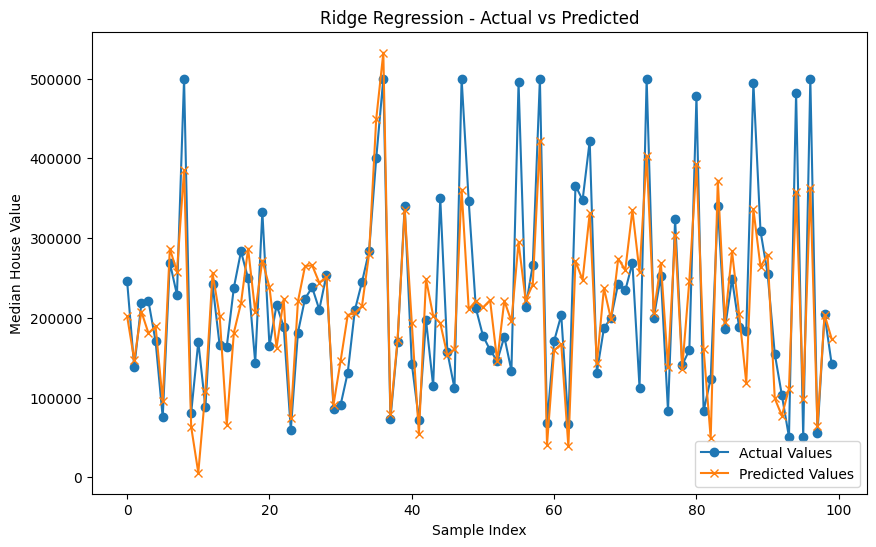

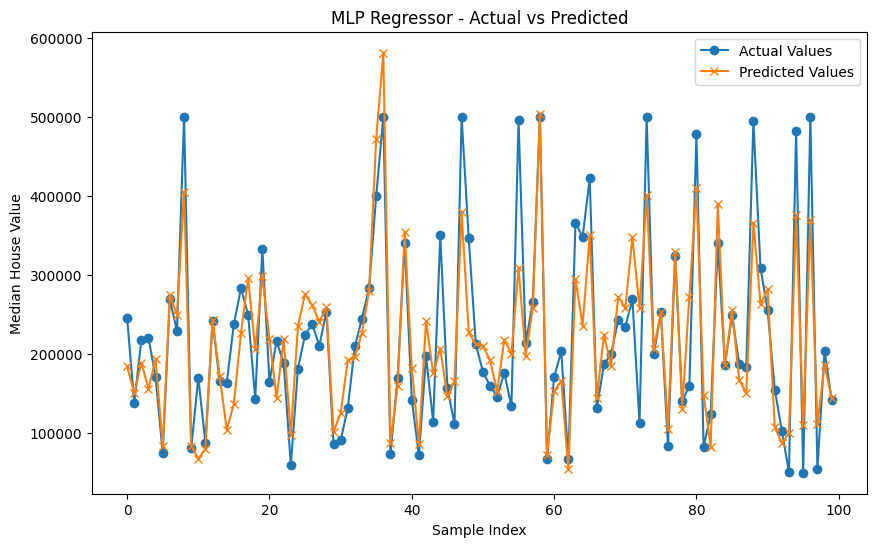

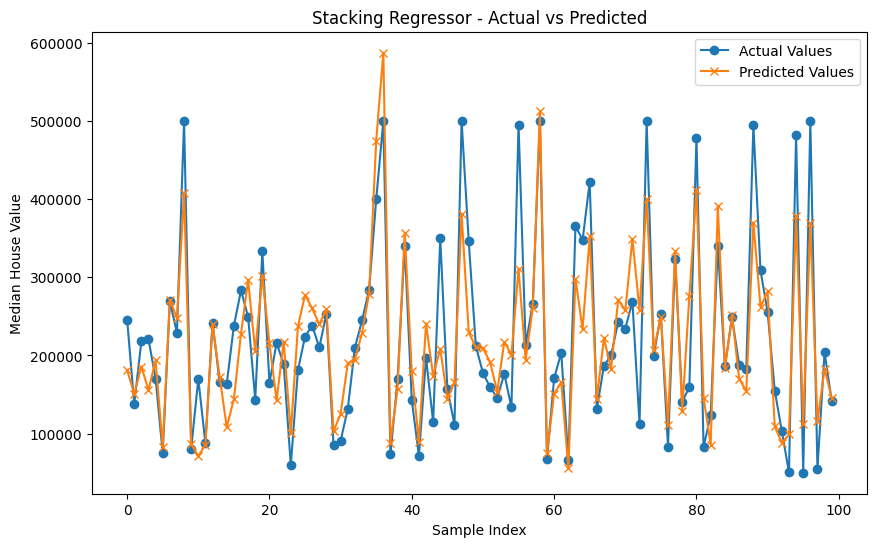

In [13]:
# 6. Vẽ biểu đồ so sánh giá trị thực tế và dự đoán

models = {
    'Linear Regression': y_pred_lr,
    'Ridge Regression': y_pred_ridge,
    'MLP Regressor': y_pred_mlp,
    'Stacking Regressor': y_pred_stack_mlp
}

for model_name, y_pred in models.items():
    plt.figure(figsize=(10,6))
    plt.plot(y_test.values[:100], label='Actual Values', marker='o')
    plt.plot(y_pred[:100], label='Predicted Values', marker='x')
    plt.title(f"{model_name} - Actual vs Predicted")
    plt.xlabel('Sample Index')
    plt.ylabel('Median House Value')
    plt.legend()
    plt.show()
